## Checkout Funnel Optimization using A/B Testing
### 'Hypothesis: Simplifying the number of steps in the checkout process increases the Conversion Rate by 5% or more'







### Step - 1: Importing the necessary libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

### Step - 2: Data Extraction and Exploration
#### **Loading original data, i.e., the Control Group**

In [143]:
df_users = pd.read_csv("user_table.csv")
df_search_page = pd.read_csv("search_page.csv")
df_cart = pd.read_csv("cart_table.csv")
df_details = pd.read_csv("personal_and_bill_details_page.csv")
df_confirmation = pd.read_csv("payment_confirmation_table.csv")

In [144]:
df_list = [df_users, df_search_page, df_cart, df_details, df_confirmation]

for df in df_list:
  print(df.shape)
  print(df.head(3), "\n")

(90400, 4)
   user_id        date   device     sex
0   450007  2015-02-28  Desktop  Female
1   756838  2015-01-13  Desktop    Male
2   568983  2015-04-09  Desktop    Male 

(90400, 2)
   user_id         page
0   313593  search_page
1   468315  search_page
2   264005  search_page 

(39885, 2)
   user_id  page
0    15866  cart
1   347058  cart
2   577020  cart 

(5540, 2)
   user_id                       page
0   253019  personal_and_bill_details
1   310478  personal_and_bill_details
2   304081  personal_and_bill_details 

(452, 2)
   user_id                       page
0   123100  payment_confirmation_page
1   704999  payment_confirmation_page
2   407188  payment_confirmation_page 



In [100]:
df_users.duplicated().sum()

np.int64(0)

### Step - 3: Creating Control Group Funnel Summary
####**Summarizing data to get the stats (visit count per user, gender, device) for each page/stage of the funnel**

In [101]:
def page_summary(df, column_name):
  return df.groupby("user_id").size().reset_index(name = column_name)

search_page_summary = page_summary(df_search_page, "search_page_visits")
cart_summary = page_summary(df_cart, "cart_visits")
details_page_summary = page_summary(df_details, "details_page_visits")
confirmation_summary = page_summary(df_confirmation, "confirmation_visits")

In [145]:
cart_summary.head()

,user_id,cart_visits
0,17,1
1,37,1
2,38,1
3,239,1
4,242,1


In [146]:
# Merging all the summaries into a single dataframe for user-level control funnel

control_df = df_users.merge(search_page_summary, how = "left", on = "user_id")\
                     .merge(cart_summary, how="left", on = "user_id")\
                     .merge(details_page_summary, how ="left", on = "user_id")\
                     .merge(confirmation_summary, how = "left", on = "user_id")

print(control_df.shape)
control_df.head()

(90400, 8)


,user_id,date,device,sex,search_page_visits,cart_visits,details_page_visits,confirmation_visits
0,450007,2015-02-28,Desktop,Female,1,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,1,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,1,NaN,NaN,NaN
3,190794,2015-02-18,Desktop,Female,1,1.0,NaN,NaN
4,537909,2015-01-15,Desktop,Male,1,NaN,NaN,NaN


In [152]:
control_df.fillna(0, inplace = True)
control_df.head()
control_df.confirmation_visits.unique()

array([0., 1.])

In [153]:
control_df[["cart_visits", "details_page_visits", "confirmation_visits"]] = control_df[["cart_visits", "details_page_visits", "confirmation_visits"]]\
                                                                                   .astype("int")
control_df["user_id"] = control_df["user_id"].astype("str")

control_df.drop("date", axis = 1, inplace=True)
control_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              90400 non-null  object
 1   device               90400 non-null  object
 2   sex                  90400 non-null  object
 3   search_page_visits   90400 non-null  int64 
 4   cart_visits          90400 non-null  int64 
 5   details_page_visits  90400 non-null  int64 
 6   confirmation_visits  90400 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 4.8+ MB


In [154]:
# Creating a new column "Converted" in control_df to track the conversion rate

control_df["converted"] = (control_df["confirmation_visits"] > 0).astype("int")
control_df.head()

,user_id,device,sex,search_page_visits,cart_visits,details_page_visits,confirmation_visits,converted
0,450007,Desktop,Female,1,0,0,0,0
1,756838,Desktop,Male,1,0,0,0,0
2,568983,Desktop,Male,1,0,0,0,0
3,190794,Desktop,Female,1,1,0,0,0
4,537909,Desktop,Male,1,0,0,0,0


### Step - 4: Variant Group Simulation for the Simplified Funnel
#### **Reducing the number of steps in the funnel by combining the Bill and Personal Details page and Payment Confirmation page, while streamlining the Search page**

In [155]:
num_variant_users = int(len(control_df))
variant_users_df = control_df.sample(num_variant_users, random_state = 42).copy()
variant_users_df.head()

,user_id,device,sex,search_page_visits,cart_visits,details_page_visits,confirmation_visits,converted
63713,429437,Desktop,Female,1,1,1,0,0
75762,360540,Desktop,Female,1,0,0,0,0
82703,774178,Desktop,Male,1,1,0,0,0
68365,930380,Desktop,Female,1,1,0,0,0
712,278349,Desktop,Male,1,0,0,0,0


In [156]:
variant_users_df["checkout_visits"] = ((variant_users_df["details_page_visits"] > 0) | (variant_users_df["confirmation_visits"] > 0)).astype("int")
variant_users_df.head()

,user_id,device,sex,search_page_visits,cart_visits,details_page_visits,confirmation_visits,converted,checkout_visits
63713,429437,Desktop,Female,1,1,1,0,0,1
75762,360540,Desktop,Female,1,0,0,0,0,0
82703,774178,Desktop,Male,1,1,0,0,0,0
68365,930380,Desktop,Female,1,1,0,0,0,0
712,278349,Desktop,Male,1,0,0,0,0,0


In [157]:
variant_users_df["converted"] = variant_users_df["checkout_visits"]
variant_users_df.head()

,user_id,device,sex,search_page_visits,cart_visits,details_page_visits,confirmation_visits,converted,checkout_visits
63713,429437,Desktop,Female,1,1,1,0,1,1
75762,360540,Desktop,Female,1,0,0,0,0,0
82703,774178,Desktop,Male,1,1,0,0,0,0
68365,930380,Desktop,Female,1,1,0,0,0,0
712,278349,Desktop,Male,1,0,0,0,0,0


In [158]:
variant_users_df.drop(columns = ["details_page_visits", "confirmation_visits"], axis = 1, inplace=True)
variant_users_df.head()

,user_id,device,sex,search_page_visits,cart_visits,converted,checkout_visits
63713,429437,Desktop,Female,1,1,1,1
75762,360540,Desktop,Female,1,0,0,0
82703,774178,Desktop,Male,1,1,0,0
68365,930380,Desktop,Female,1,1,0,0
712,278349,Desktop,Male,1,0,0,0


In [159]:
# Streamlining the search page increases cart visits

np.random.seed(42)
variant_users_df["cart_visits"] = np.random.randint(0, 2, size = num_variant_users)
variant_users_df.head()

,user_id,device,sex,search_page_visits,cart_visits,converted,checkout_visits
63713,429437,Desktop,Female,1,0,1,1
75762,360540,Desktop,Female,1,1,0,0
82703,774178,Desktop,Male,1,0,0,0
68365,930380,Desktop,Female,1,0,0,0
712,278349,Desktop,Male,1,0,0,0


In [160]:
variant_users_df["group"] = "variant"
control_df["group"] = "control"

ab_df = pd.concat([control_df, variant_users_df], ignore_index= True)
print(ab_df.shape)
ab_df.head()

(180800, 10)


,user_id,device,sex,search_page_visits,cart_visits,details_page_visits,confirmation_visits,converted,group,checkout_visits
0,450007,Desktop,Female,1,0,0.0,0.0,0,control,NaN
1,756838,Desktop,Male,1,0,0.0,0.0,0,control,NaN
2,568983,Desktop,Male,1,0,0.0,0.0,0,control,NaN
3,190794,Desktop,Female,1,1,0.0,0.0,0,control,NaN
4,537909,Desktop,Male,1,0,0.0,0.0,0,control,NaN


In [161]:
ab_df.replace(np.nan, 0, inplace = True)
ab_df.head()

,user_id,device,sex,search_page_visits,cart_visits,details_page_visits,confirmation_visits,converted,group,checkout_visits
0,450007,Desktop,Female,1,0,0.0,0.0,0,control,0.0
1,756838,Desktop,Male,1,0,0.0,0.0,0,control,0.0
2,568983,Desktop,Male,1,0,0.0,0.0,0,control,0.0
3,190794,Desktop,Female,1,1,0.0,0.0,0,control,0.0
4,537909,Desktop,Male,1,0,0.0,0.0,0,control,0.0


### Step - 5: Segmentation Analysis Using Chi-Square Test

In [162]:
# Creating contingency table for gender

contingency_gender = pd.crosstab(ab_df["sex"], ab_df["converted"])

chi_2, p_value, dof, expected = chi2_contingency(contingency_gender)
print(f"The Chi-Square Statistic for gender is: {chi_2: .4f}")
print(f"The p-value for the Chi-square test is: {p_value: .4f}")

total_users_per_gender = contingency_gender.sum(axis=1)
contingency_gender["conversion_rate"] = (contingency_gender[1]/total_users_per_gender)*100
contingency_gender.reset_index(inplace=True)

The Chi-Square Statistic for gender is:  7.8393
The p-value for the Chi-square test is:  0.0051


In [163]:
# Creating contingency table for device

contingency_device = pd.crosstab(ab_df["device"], ab_df["converted"])

chi_2, p_value, dof, expected = chi2_contingency(contingency_device)
print(f"The Chi-Square Statistic for device is: {chi_2: .4f}")
print(f"The p-value for the Chi-square test is: {p_value: .4f}")

total_users_per_device = contingency_device.sum(axis=1)
contingency_device["conversion_rate"] = (contingency_device[1]/total_users_per_device)*100
contingency_device.reset_index(inplace=True)

The Chi-Square Statistic for device is:  922.2552
The p-value for the Chi-square test is:  0.0000


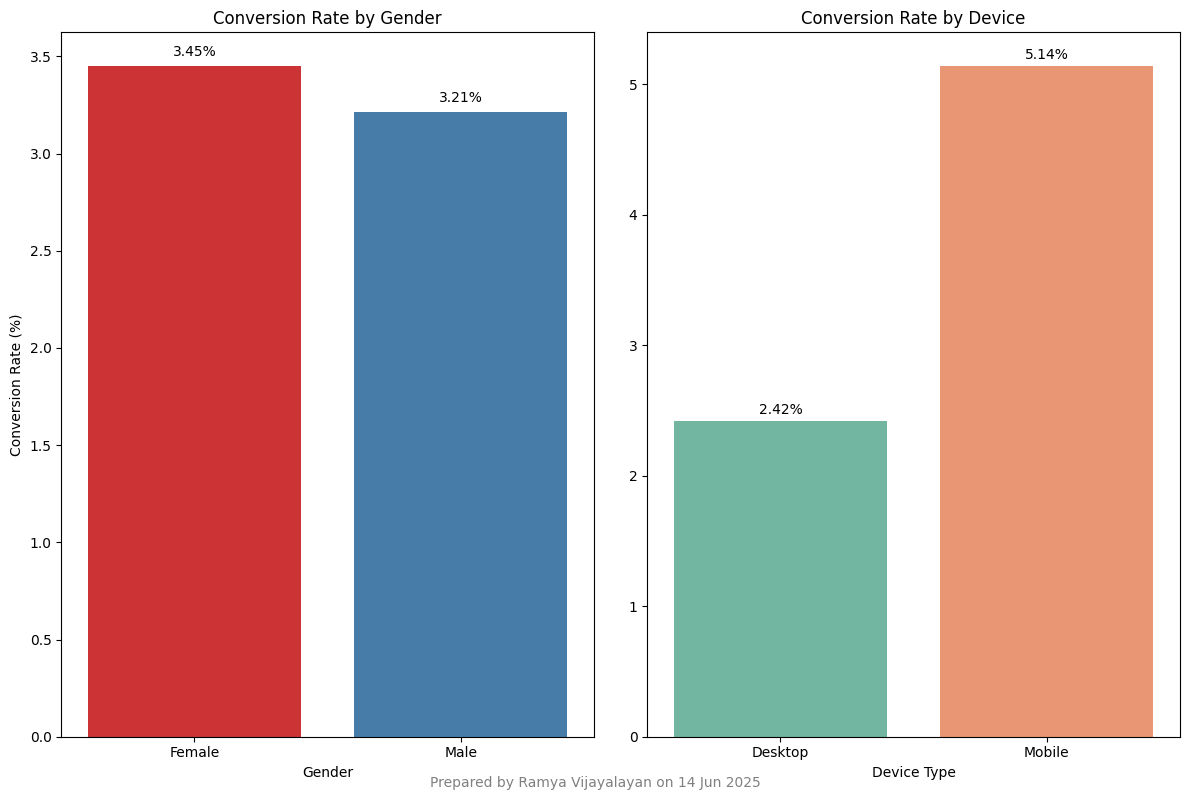

In [234]:
# Visualizing the results

fig, (ax1, ax2) = plt.subplots(ncols= 2, figsize = (12,8))
sns.barplot(x = "sex", y = "conversion_rate", data = contingency_gender, palette = "Set1", ax = ax1)
sns.barplot(x = "device", y = "conversion_rate", data = contingency_device, palette = "Set2", ax = ax2)
ax1.set_title("Conversion Rate by Gender")
ax2.set_title("Conversion Rate by Device")
ax1.set_xlabel("Gender")
ax1.set_ylabel("Conversion Rate (%)")
ax2.set_xlabel("Device Type")
ax2.set_ylabel(" ")

# Adding labels for each bar
for index, row in contingency_gender.iterrows():
  ax1.text(index, row["conversion_rate"] + 0.05, f"{row['conversion_rate']:0.2f}%", ha = "center", fontsize = 10)

for index, row in contingency_device.iterrows():
  ax2.text(index, row["conversion_rate"] + 0.05, f"{row['conversion_rate']:0.2f}%", ha="center", fontsize = 10)

plt.tight_layout()
plt.savefig("Segmentation Analysis by Gender and Device.png", dpi = 300)
plt.show()

### Step - 6: A/B Testing with Proportions Z-Test: Assessing Hypothesis Significance

In [165]:
# Grouped conversion summary

group_conv = ab_df.groupby("group")["converted"].agg(converted_users = "sum", sample_size = "count")
group_conv

,converted_users,sample_size
group,,
control,452,90400
variant,5572,90400


#### **a) Proportions Z-Test for validating the Conversion Uplift**

In [166]:
# Proportions Z-test

conversions_variant = group_conv.loc["variant", "converted_users"]
conversions_control = group_conv.loc["control", "converted_users"]
sample_size_variant = group_conv.loc["variant", "sample_size"]
sample_size_control = group_conv.loc["control", "sample_size"]
z_stat, p_value = proportions_ztest(count = [conversions_variant, conversions_control],
                                    nobs = [sample_size_variant, sample_size_control])

print(f"The Z Statistic is: {z_stat : .4f}")
print(f"The P-value for the Z Test is: {p_value: .4f}")

The Z Statistic is:  67.0943
The P-value for the Z Test is:  0.0000


In [167]:
group_conv["conversion_rate_pct"] = (group_conv["converted_users"]/group_conv["sample_size"])*100
group_conv = group_conv.reset_index()
group_conv.columns = ["group", "converted_users", "sample_size", "conversion_rate_pct"]
group_conv

,group,converted_users,sample_size,conversion_rate_pct
0,control,452,90400,0.500000
1,variant,5572,90400,6.163717


#### **b) Calculating Confidence Interval for the Uplift percentage**

In [168]:
p1 = group_conv.loc[0, "conversion_rate_pct"]/100
p2 = group_conv.loc[1, "conversion_rate_pct"]/100
uplift = p2 - p1

# Standard Error of Difference
se_diff = np.sqrt((p1*(1-p1)/sample_size_control) + (p2*(1-p2)/sample_size_variant))

# Computing Confidence Interval
z_critical = 1.96
lower_bound = (uplift - z_critical * se_diff)*100
upper_bound = (uplift + z_critical * se_diff)*100
print(f"Confidence Interval of 95% for the Uplift is: [{lower_bound: 0.2f}%, {upper_bound: 0.2f}%]")

Confidence Interval of 95% for the Uplift is: [ 5.50%,  5.83%]


### Step - 7: Visualizing the Results

#### **a) Conversion Rate Comparison Across Funnel Groups**

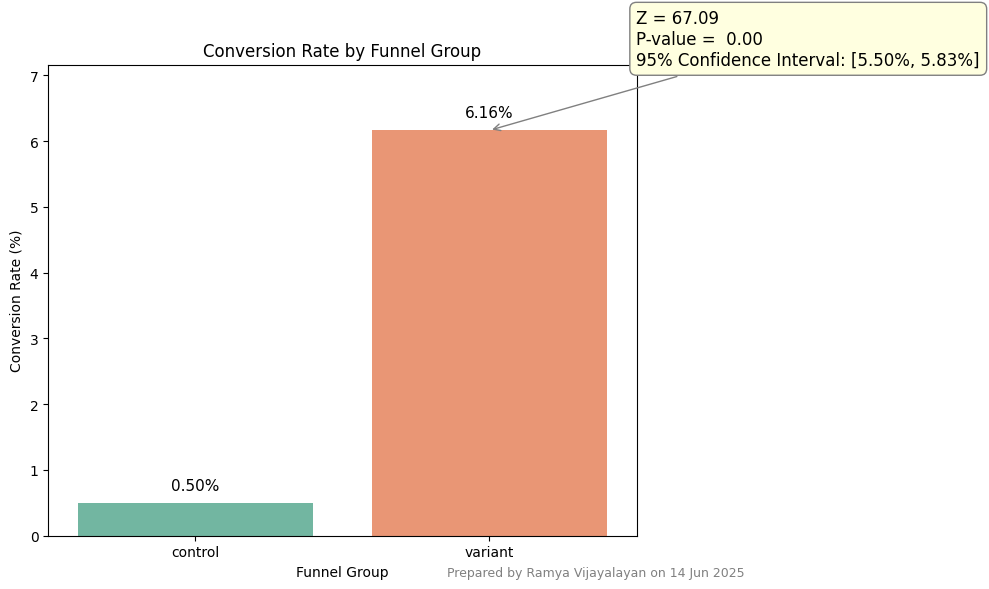

In [235]:
plt.figure(figsize=(10,6))
sns.barplot(x = "group", y = "conversion_rate_pct", data = group_conv,
            palette = "Set2")
plt.title("Conversion Rate by Funnel Group")
plt.xlabel("Funnel Group")
plt.ylabel("Conversion Rate (%)")
plt.ylim(0, group_conv["conversion_rate_pct"].max() + 1)

for index, row in group_conv.iterrows():
  plt.text(index, row["conversion_rate_pct"] + 0.2, f"{row['conversion_rate_pct']:0.2f}%",
           ha = "center", fontsize = 11)

# Adding annotation box with statistical metrics
stats_text = (
    f"Z = {z_stat:.2f}\n"
    f"P-value = {p_value: .2f}\n"
    f"95% Confidence Interval: [{lower_bound:.2f}%, {upper_bound:.2f}%]"
)

plt.annotate(stats_text,
             xy=(1, group_conv["conversion_rate_pct"].max()),  # anchor point
             xytext=(1.5, group_conv["conversion_rate_pct"].max() + 1),  # text position
             textcoords='data',
             fontsize=12,
             bbox=dict(boxstyle="round, pad=0.4", fc="lightyellow", ec="gray", lw=1),
             arrowprops=dict(arrowstyle="->", color='gray'))

plt.tight_layout()
plt.savefig("Conversion Rate Comparison Chart.png", dpi = 300)
plt.show()

#### **A/B Test Funnel Comparison: User Journeys in Control and Variant Groups**

In [170]:
funnel_summary = ab_df.groupby("group").sum().select_dtypes(include = "number")
funnel_summary

,search_page_visits,cart_visits,details_page_visits,confirmation_visits,converted,checkout_visits
group,,,,,,
control,90400,39885,5540.0,452.0,452,0.0
variant,90400,45235,0.0,0.0,5572,5572.0


In [171]:
control_stages = ["search_page", "cart", "details_page", "payment_confirmation"]
control_values = list(funnel_summary.iloc[0, 0:4])

variant_stages = ["streamlined_search_page", "unified_cart", "payment_confirmation"]
variant_values = [90400, 45235, 5572]

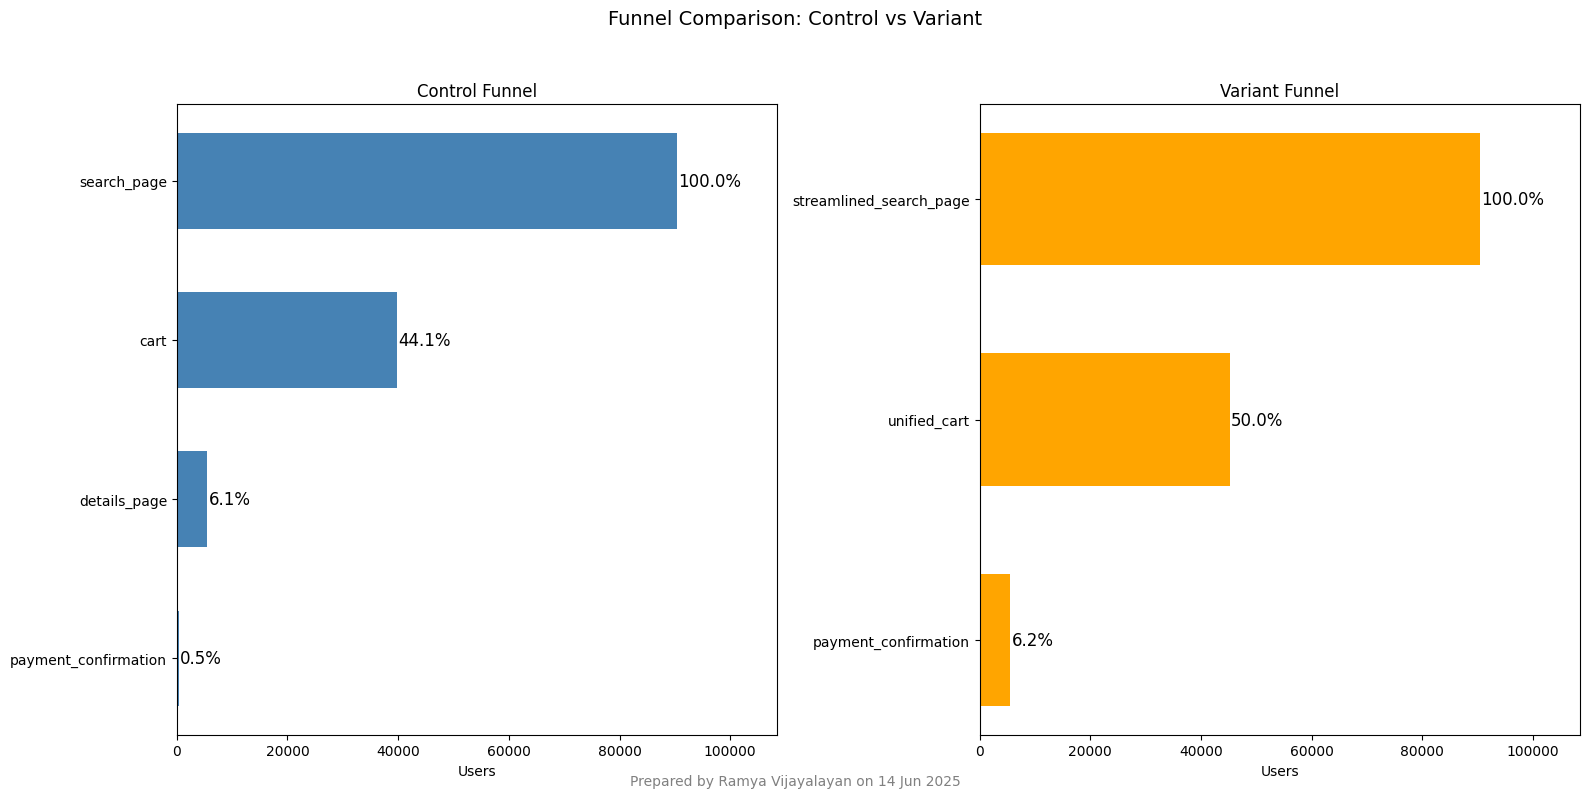

In [236]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8), sharex=False)

# Control funnel
for i in range(len(control_values)):
  ax1.barh(y=i, width=control_values[i], height=0.6, color='steelblue')
  pct = control_values[i] / control_values[0] * 100
  ax1.text(control_values[i] + 200, i, f"{pct:.1f}%", va='center', fontsize=12)

ax1.set_yticks(range(len(control_stages)))
ax1.set_yticklabels(control_stages[::1])
ax1.invert_yaxis()
ax1.set_title("Control Funnel")
ax1.set_xlabel("Users")
ax1.set_xlim(0, control_values[0] * 1.2)

# Variantfunnel
for i in range(len(variant_values)):
  ax2.barh(y=i, width=variant_values[i], height=0.6, color='orange')
  pct = variant_values[i] / variant_values[0] * 100
  ax2.text(variant_values[i] + 200, i, f"{pct:.1f}%", va='center', fontsize=12)

ax2.set_yticks(range(len(variant_stages)))
ax2.set_yticklabels(variant_stages[::1])
ax2.invert_yaxis()
ax2.set_title("Variant Funnel")
ax2.set_xlabel("Users")
ax2.set_xlim(0, variant_values[0]*1.2)
plt.suptitle("Funnel Comparison: Control vs Variant", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Funnel Comparison Chart.png", dpi = 300)
plt.show()

### Step - 7: Exporting the Dataframes and Plots

In [185]:
ab_df.to_csv("AB Test Dataset.csv", index = False)
contingency_gender.to_csv("Segmentation Analysis - Gender", index = False)
contingency_device.to_csv("Segmentation Analysis - Device", index = False)

In [186]:
from google.colab import files

files.download("AB Test Dataset.csv")
files.download("Segmentation Analysis - Gender")
files.download("Segmentation Analysis - Device")
files.download("Segmentation Analysis by Gender and Device.png")
files.download("Conversion Rate Comparison Chart.png")
files.download("Funnel Comparison Chart.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>